In [1]:
import os 
os.chdir('../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np 
from IPython.display import display
import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.plot_fairness import prob_recid_conditioned_sensitive_attr

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa_analysis_all\psa-analysis-public-repo


#### Read in data 



In [5]:
kentucky_data = pd.read_csv("kentucky/data/processed/kentucky_data.csv")

### Compute group balance 

In [6]:
## kentucky
kentucky_attrs = kentucky_data[['person_id', 'screening_date', 'sex', 'race']]

kentucky_attrs = (pd.melt(kentucky_attrs, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                .rename({'variable': 'Attribute',
                         'value': 'Attribute Value'},
                        axis=1))

kentucky_attrs = kentucky_attrs.groupby(["Attribute", "Attribute Value"]).size().to_frame('n_inds').reset_index()

# check totals are same for race and sex
assert (kentucky_attrs[kentucky_attrs['Attribute']=='race']['n_inds'].sum()) == (kentucky_attrs[kentucky_attrs['Attribute']=='sex']['n_inds'].sum())
total_inds = kentucky_attrs[kentucky_attrs['Attribute']=='race']['n_inds'].sum()

# add percent col
kentucky_attrs["% total"] = ((kentucky_attrs['n_inds'] / total_inds) * 100).apply(lambda x: round(x, 2))
kentucky_attrs

,Attribute,Attribute Value,n_inds,% total
0,race,Asian,714,0.32
1,race,Black,37936,17.02
2,race,Indian,177,0.08
3,race,Race Unknown,4171,1.87
4,race,White,179871,80.71
5,sex,0,69106,31.01
6,sex,1,153763,68.99


In [4]:
## write result
kentucky_attrs.to_csv("kentucky/logs/fairness_results/data_visualizations/kentucky_racial_distr.csv")

In [7]:
# put individuals from Indian and Asian groups into Other, 
# do some renaming for consistency with Broward 

for decoder_name, decoder_dict in settings['decoders'].items():
    kentucky_data = kentucky_data.replace({decoder_name: decoder_dict})

kentucky_data.rename(columns=settings['decoders']['label'], inplace=True)

### Check for recidivism balance across all groups for all problems

i.e. $P(Y = 1 | group = g_1)$

In [8]:
total_inds = kentucky_data.shape[0]
# unpivot the sensitive attributes
kentucky_attrs = (pd.melt(kentucky_data, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                   .rename({'variable': 'Attribute',
                            'value': 'Attribute Value'},
                            axis=1)
                    # concatenate the label info 
                   .merge(kentucky_data[['person_id', 'screening_date'] + settings["labels"]], 
                          on = ['person_id', 'screening_date'],
                          how = 'left'))

kentucky_recid_balance_groups = {}
for label in settings['labels']:
    kentucky_attrs_label = kentucky_attrs[['person_id', 'screening_date', 'Attribute', 'Attribute Value'] + [label]]

    res = (kentucky_attrs_label.groupby(['Attribute', 'Attribute Value'])
                              .sum()[label]
                              .to_frame('n_inds_recid')
                              .reset_index())
    
    res['total_inds'] = total_inds
    total_inds_with_attr = (kentucky_attrs_label
                           .groupby(['Attribute', 'Attribute Value'])
                           .size()
                           .to_frame("total_inds_with_attr")
                           .reset_index())
    
    res = res.merge(total_inds_with_attr, on = ['Attribute', 'Attribute Value'], how='left')
    res['P(Y = 1 | Attr = attr)'] = res['n_inds_recid']/res['total_inds_with_attr']
    res['P(Y = 1,  Attr = attr)'] = res['n_inds_recid']/total_inds
    res['label'] = label
    
    res.set_index('label')
    kentucky_recid_balance_groups[label] = res

In [9]:
# merge dictionary into 1 df
kentucky_recid_balance_df = (pd.concat(kentucky_recid_balance_groups, axis=0)
                            .reset_index()
                            .iloc[:, 2:])[['label', 'Attribute', 'Attribute Value', 'P(Y = 1 | Attr = attr)']]
kentucky_recid_balance_df.head()

,label,Attribute,Attribute Value,P(Y = 1 | Attr = attr)
0,general_two_year,race,African-American,0.224562
1,general_two_year,race,Caucasian,0.213008
2,general_two_year,race,Other,0.076452
3,general_two_year,sex,female,0.199114
4,general_two_year,sex,male,0.217608


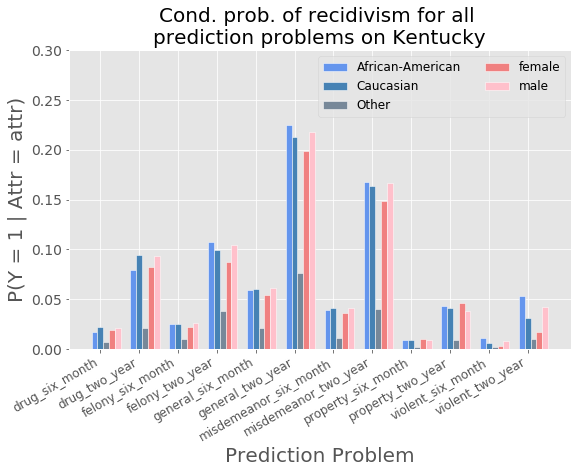

In [10]:
prob_recid_conditioned_sensitive_attr(kentucky_recid_balance_df, 
                                      dataset_name = "Kentucky",
                                      save_path = "kentucky/logs/fairness_results/data_visualizations/kentucky_prob_recid_conditional.pdf")
